In [ ]:
# Predictive Analytics for Silver — Step 1
# Authors: <FAQ>
# Date: <11/14/2025>
# Purpose: Setup environment and fetch historical silver prices

In [ ]:
# ----------------------------------------------------------
# Installing required libraries
# ----------------------------------------------------------
# yfinance      → used to download financial data (silver prices)
# pandas        → used for data handling and manipulation
# numpy         → used for numerical operations
# matplotlib    → used to plot graphs
# seaborn       → used to enhance graph styling
# scikit-learn  → used later for machine learning models
# statsmodels   → used for time series forecasting (ARIMA)
# tensorflow    → used for deep learning (LSTM models)
# ----------------------------------------------------------
!pip install --quiet yfinance pandas matplotlib seaborn scikit-learn statsmodels tensorflow

# ----------------------------------------------------------
# Importing the installed libraries
# ----------------------------------------------------------

import yfinance as yf           # Downloading finance data
import pandas as pd             # Working with dataframes
import numpy as np              # Numerical operations
import matplotlib.pyplot as plt # Plotting graphs
import seaborn as sns           # Better graph aesthetics

from sklearn.model_selection import train_test_split     # Train-test splitting
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Error metrics

import statsmodels.api as sm    # Time series models

# Improve plot visuals in Colab
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
sns.set(style="darkgrid")


In [ ]:
# ----------------------------------------------------------
# STEP 1: DOWNLOAD HISTORICAL SILVER PRICES
# ----------------------------------------------------------

# Define the date range for which we want the data
start_date = "2010-01-01"      # Start date
end_date = "2025-11-01"        # End date

# Silver futures ticker on Yahoo Finance = "SI=F"
symbol = "SI=F"

# Downloading data using yfinance
# progress=False hides the download progress bar for cleaner output
data = yf.download(symbol, start=start_date, end=end_date, progress=False)

# Optional: Save the data as a CSV file in Colab storage
data.to_csv('/content/silver_prices.csv')

# Print how many rows and columns we downloaded
print("Downloaded rows:", data.shape[0], "columns:", data.shape[1])

# Show the first 5 rows to check the structure
data.head()


/tmp/ipython-input-1179183463.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date, progress=False)


Downloaded rows: 3982 columns: 5


Price,Close,High,Low,Open,Volume
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F
Date,,,,,
2010-01-04,17.440001,17.440001,16.870001,17.440001,28
2010-01-05,17.781000,17.820000,17.575001,17.781000,38
2010-01-06,18.163000,18.190001,17.840000,18.163000,19
2010-01-07,18.333000,18.333000,18.090000,18.333000,7
2010-01-08,18.458000,18.458000,18.120001,18.458000,3



Data summary:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3982 entries, 2010-01-04 to 2025-10-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   (Close, SI=F)   3982 non-null   float64
 1   (High, SI=F)    3982 non-null   float64
 2   (Low, SI=F)     3982 non-null   float64
 3   (Open, SI=F)    3982 non-null   float64
 4   (Volume, SI=F)  3982 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 186.7 KB


None


Missing values per column:
Price   Ticker
Close   SI=F      0
High    SI=F      0
Low     SI=F      0
Open    SI=F      0
Volume  SI=F      0
dtype: int64


,,count,mean,std,min,25%,50%,75%,max
Price,Ticker,,,,,,,,
Close,SI=F,3982.0,22.793854,7.091471,11.735,16.994250,21.113500,27.371999,53.022999
High,SI=F,3982.0,22.965579,7.196065,12.205,17.060999,21.237000,27.548749,53.340000
Low,SI=F,3982.0,22.627108,6.989649,11.735,16.914000,20.952500,27.170000,51.785000
Open,SI=F,3982.0,22.803608,7.097372,12.070,16.980000,21.094999,27.322250,53.215000
Volume,SI=F,3982.0,1796.778252,10068.046911,0.000,10.000000,48.000000,163.750000,170297.000000


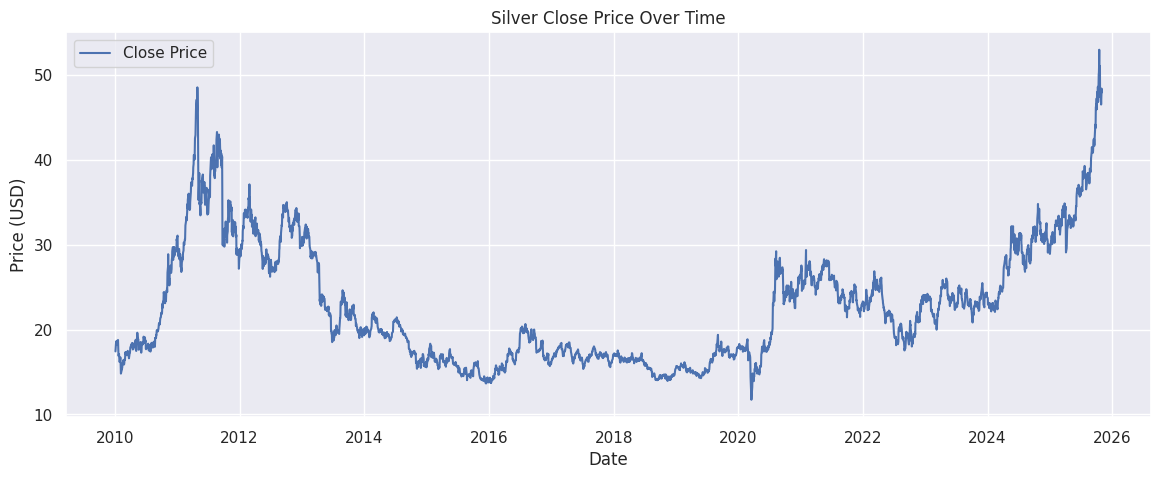

In [ ]:
# ----------------------------------------------------------
# STEP 2: Basic Data Checks
# ----------------------------------------------------------

# Print summary information about the dataset (column names, types, null counts)
print("\nData summary:")
display(data.info())

# Check how many missing values are present in each column
print("\nMissing values per column:")
print(data.isnull().sum())

# Display statistical summary (mean, min, max, etc.)
display(data.describe().T)

# ----------------------------------------------------------
# STEP 3: Plotting the Silver Price (Close Price)
# ----------------------------------------------------------

# Check if the column 'Close' exists in the dataset (just in case)
if 'Close' in data.columns:

    # Create a time-series plot of the closing price
    plt.figure(figsize=(14,5))
    plt.plot(data.index, data['Close'], label='Close Price')

    # Add graph title and labels
    plt.title('Silver Close Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()

    # Display the plot
    plt.show()

else:
    # If 'Close' column is missing, tell the user to check the columns
    print("No 'Close' column found. Columns available are:")
    print(data.columns)


In [ ]:
# ----------------------------------------------------------
# STEP 2-A: HANDLING MISSING VALUES  Repeating cleaning
# ----------------------------------------------------------

# Check missing values again
print("Missing values before cleaning:")
print(data.isnull().sum())

# Forward fill → replaces missing value with previous day's value
data = data.ffill()

# Backward fill → (just in case initial values were missing)
data = data.bfill()

# Check again after cleaning
print("\nMissing values after cleaning:")
print(data.isnull().sum())


Missing values before cleaning:
Price   Ticker
Close   SI=F      0
High    SI=F      0
Low     SI=F      0
Open    SI=F      0
Volume  SI=F      0
dtype: int64

Missing values after cleaning:
Price   Ticker
Close   SI=F      0
High    SI=F      0
Low     SI=F      0
Open    SI=F      0
Volume  SI=F      0
dtype: int64


In [ ]:
# ----------------------------------------------------------
# STEP 2-B: FEATURE ENGINEERING
# Creating useful financial indicators for prediction
# ----------------------------------------------------------

# 1. DAILY RETURNS (how much price changes each day)
# Formula: (Today's Close - Yesterday's Close) / Yesterday's Close
data['Daily_Return'] = data['Close'].pct_change()

# 2. MOVING AVERAGES (smoothed price trends)
data['MA_7'] = data['Close'].rolling(window=7).mean()     # 7-day moving average
data['MA_30'] = data['Close'].rolling(window=30).mean()   # 30-day moving average
data['MA_90'] = data['Close'].rolling(window=90).mean()   # 90-day moving average
data['MA_200'] = data['Close'].rolling(window=200).mean()   # Long-term major trend

# 3. ROLLING VOLATILITY (risk measure)
# Standard deviation of returns over 30 days
data['Volatility_30'] = data['Daily_Return'].rolling(window=30).std()

# Display the updated dataset
data.tail(10)


Price,Close,High,Low,Open,Volume,Daily_Return,MA_7,MA_30,MA_90,MA_200,Volatility_30
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F,,,,,,
Date,,,,,,,,,,,
2025-10-20,51.118999,51.430000,50.139999,50.415001,652,0.025168,50.351571,45.890466,40.552600,36.217515,0.025147
2025-10-21,47.450001,50.805000,47.415001,50.805000,329,-0.071774,50.424714,46.109533,40.676700,36.303055,0.028804
2025-10-22,47.460999,48.115002,47.220001,47.889999,347,0.000232,50.043428,46.320466,40.799833,36.388125,0.028819
2025-10-23,48.481998,48.910000,48.459999,48.470001,507,0.021512,49.781714,46.546633,40.926411,36.478275,0.028933
2025-10-24,48.376999,48.430000,47.424999,47.424999,270,-0.002166,49.396570,46.746300,41.054311,36.566205,0.028887
2025-10-27,46.562000,47.810001,45.845001,47.810001,161,-0.037518,48.473571,46.881133,41.171933,36.643560,0.029905
2025-10-28,47.125000,47.125000,46.325001,46.325001,59,0.012091,48.082285,47.036266,41.293844,36.728730,0.029932
2025-10-29,47.721001,47.721001,47.721001,47.721001,545,0.012647,47.596857,47.236233,41.427400,36.816675,0.029690


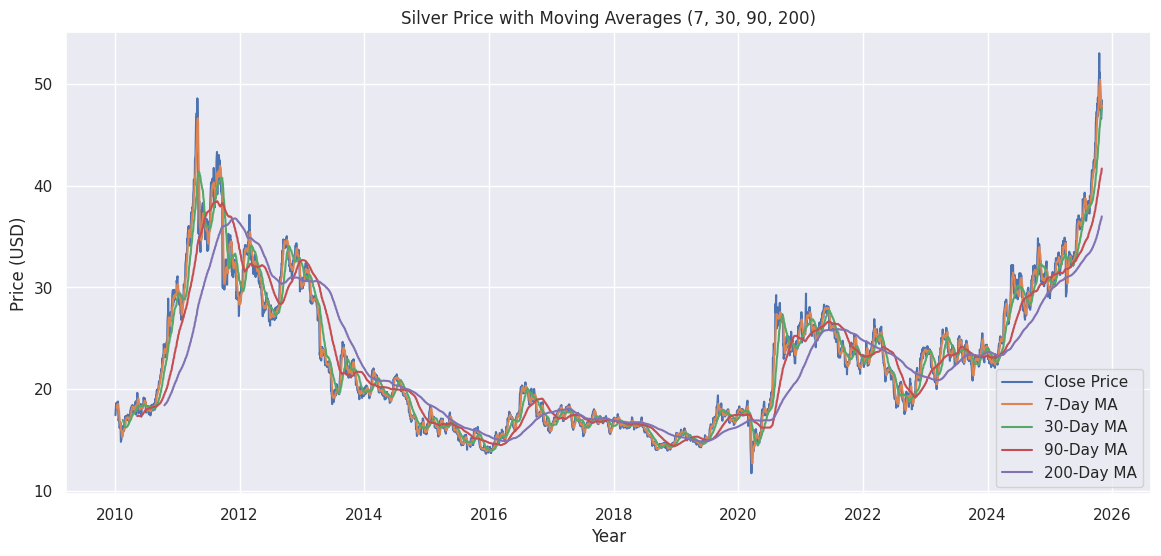

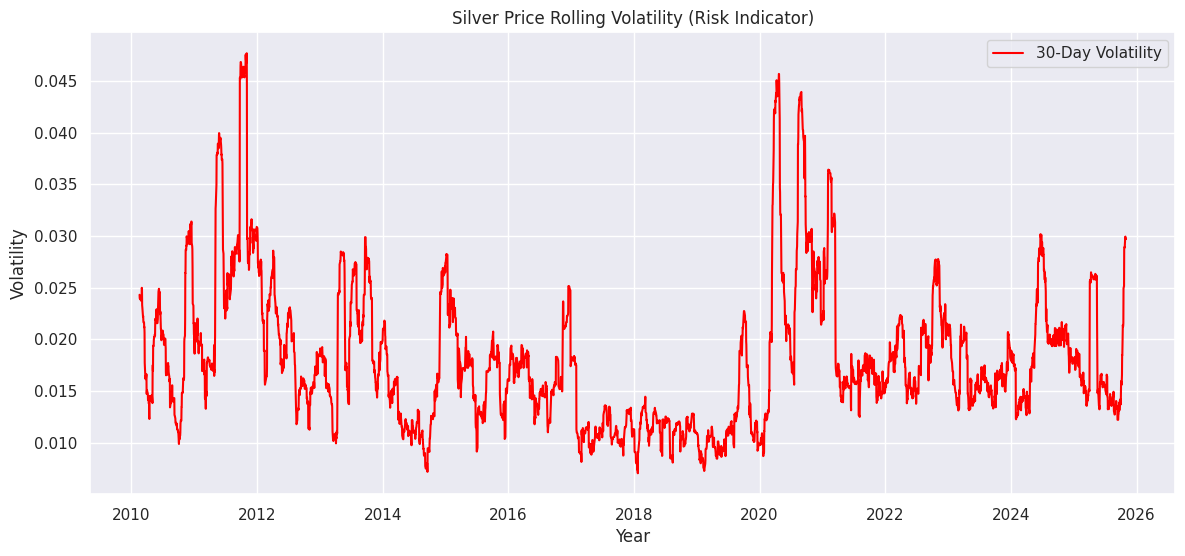

In [ ]:
# ----------------------------------------------------------
# STEP 2-C: VISUALIZE FEATURES
# ----------------------------------------------------------

# Plot Close price + Moving averages
# Plot Close price + Moving averages including MA-200
plt.figure(figsize=(14,6))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA_7'], label='7-Day MA')
plt.plot(data['MA_30'], label='30-Day MA')
plt.plot(data['MA_90'], label='90-Day MA')
plt.plot(data['MA_200'], label='200-Day MA')   # NEW LINE
plt.title("Silver Price with Moving Averages (7, 30, 90, 200)")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

# Plot rolling volatility (risk)
plt.figure(figsize=(14,6))
plt.plot(data['Volatility_30'], label='30-Day Volatility', color='red')
plt.title("Silver Price Rolling Volatility (Risk Indicator)")
plt.xlabel("Year")
plt.ylabel("Volatility")
plt.legend()
plt.show()


In [ ]:
# ----------------------------------------------------------
# STEP 3-A: REMOVE ROWS WITH NAN VALUES
# ----------------------------------------------------------

# Rolling windows (MA-200, volatility) create NaN values at the start
# We remove them so ML models don't fail

print("Rows before dropping NaN:", len(data))
data = data.dropna()
print("Rows after dropping NaN:", len(data))

# Show last few rows to ensure data looks clean
data.tail()


Rows before dropping NaN: 3982
Rows after dropping NaN: 3783


Price,Close,High,Low,Open,Volume,Daily_Return,MA_7,MA_30,MA_90,MA_200,Volatility_30
Ticker,SI=F,SI=F,SI=F,SI=F,SI=F,,,,,,
Date,,,,,,,,,,,
2025-10-27,46.562000,47.810001,45.845001,47.810001,161,-0.037518,48.473571,46.881133,41.171933,36.643560,0.029905
2025-10-28,47.125000,47.125000,46.325001,46.325001,59,0.012091,48.082285,47.036266,41.293844,36.728730,0.029932
2025-10-29,47.721001,47.721001,47.721001,47.721001,545,0.012647,47.596857,47.236233,41.427400,36.816675,0.029690
2025-10-30,48.428001,48.610001,47.134998,47.540001,370,0.014815,47.736571,47.460266,41.564544,36.902220,0.029727
2025-10-31,47.993999,48.680000,47.993999,48.439999,484,-0.008962,47.812714,47.642200,41.691300,36.984575,0.029709


In [ ]:
# ----------------------------------------------------------
# STEP 3-B: SELECT FEATURES AND TARGET
# ----------------------------------------------------------

# FEATURES (X)
# We use financial indicators you created:
features = [
    'MA_7',
    'MA_30',
    'MA_90',
    'MA_200',
    'Daily_Return',
    'Volatility_30'
]

X = data[features]   # independent variables

# TARGET (y): the price to predict (Close price)
y = data['Close']    # dependent variable

# Show shapes of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (3783, 6)
y shape: (3783, 1)


In [ ]:
# ----------------------------------------------------------
# STEP 3-C: TRAIN/TEST SPLIT
# ----------------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,     # 20% for testing
    shuffle=False       # IMPORTANT for time-series data
)

# Print shapes to confirm
print("Training set size:", X_train.shape, y_train.shape)
print("Testing set size:", X_test.shape, y_test.shape)


Training set size: (3026, 6) (3026, 1)
Testing set size: (757, 6) (757, 1)


In [ ]:
# ----------------------------------------------------------
# STEP 3-D: SCALE FEATURES (Optional but recommended)
# ----------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler

# Create the scaler
scaler = MinMaxScaler()

# Fit only on training data, not on testing
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaling done.")


Scaling done.


In [ ]:
# ----------------------------------------------------------
# STEP 4-A: TRAIN LINEAR REGRESSION MODEL
# ----------------------------------------------------------

from sklearn.linear_model import LinearRegression

# Create the model
model_lr = LinearRegression()

# Train it on the scaled training data
model_lr.fit(X_train_scaled, y_train)

print("Linear Regression model trained successfully!")


Linear Regression model trained successfully!


In [ ]:
# ----------------------------------------------------------
# STEP 4-B: MAKE PREDICTIONS ON TEST DATA
# ----------------------------------------------------------

# Predict silver prices for the test set
y_pred_lr = model_lr.predict(X_test_scaled)

# Show first 10 predictions
print("First 10 predictions:")
y_pred_lr[:10]


First 10 predictions:


array([[18.8006355 ],
       [19.19534854],
       [19.89526772],
       [19.30883865],
       [19.23068161],
       [21.00628969],
       [19.92056809],
       [20.73561741],
       [20.34697324],
       [21.18389336]])

In [ ]:
# ----------------------------------------------------------
# STEP 4-C: EVALUATE MODEL PERFORMANCE
# ----------------------------------------------------------

mae = mean_absolute_error(y_test, y_pred_lr)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print("Linear Regression Performance:")
print("MAE :", mae)
print("RMSE:", rmse)


Linear Regression Performance:
MAE : 0.4266655302593414
RMSE: 0.5758696460190534


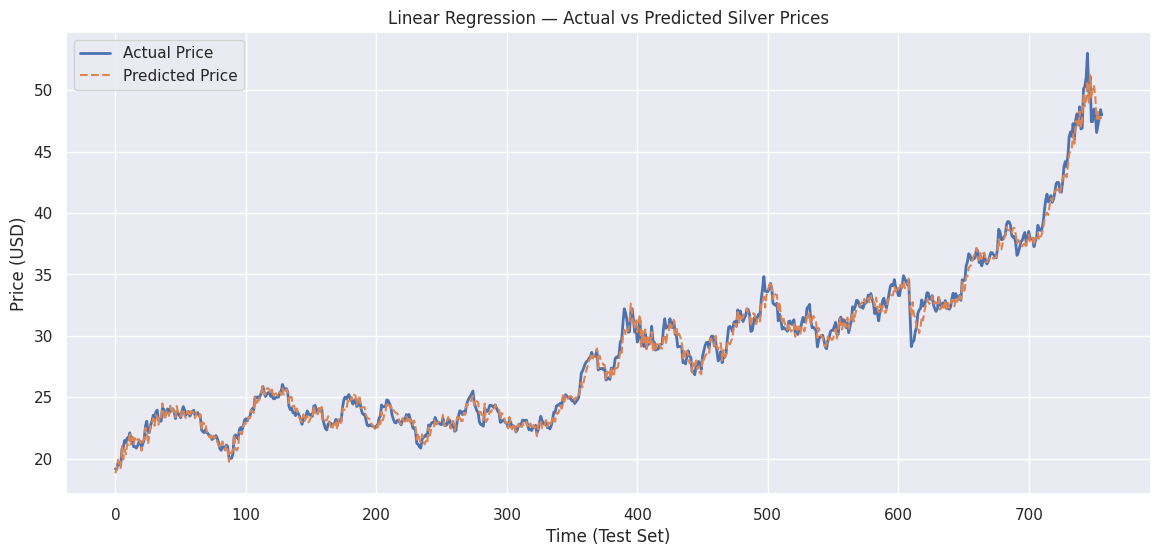

In [ ]:
# ----------------------------------------------------------
# STEP 4-D: PLOT ACTUAL VS PREDICTED PRICES
# ----------------------------------------------------------

plt.figure(figsize=(14,6))
plt.plot(y_test.values, label="Actual Price", linewidth=2)
plt.plot(y_pred_lr, label="Predicted Price", linestyle='--')
plt.title("Linear Regression — Actual vs Predicted Silver Prices")
plt.xlabel("Time (Test Set)")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()

In [ ]:
# -------------------------------
# Step 5: Model Evaluation
# -------------------------------

# Importing evaluation metrics from sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Predict the prices for the test data using the correct model name (model_lr)
y_pred = model_lr.predict(X_test)

# Calculate MAE - Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)

# Calculate MSE - Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# Calculate RMSE - Root Mean Squared Error
rmse = np.sqrt(mse)

# Print all the error values
print("Model Evaluation Metrics:")
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)


Model Evaluation Metrics:
Mean Absolute Error (MAE): 970.1706873350109
Mean Squared Error (MSE): 987812.8524841086
Root Mean Squared Error (RMSE): 993.8877464201421


In [ ]:
# ---- Step 6: Predict Next 365 Days ----

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# number of days to predict
future_days = 365

# Extract last available values for all 6 features and the last Close price
current_ma_7 = data['MA_7'].iloc[-1].item()
current_ma_30 = data['MA_30'].iloc[-1].item()
current_ma_90 = data['MA_90'].iloc[-1].item()
current_ma_200 = data['MA_200'].iloc[-1].item()
current_daily_return = data['Daily_Return'].iloc[-1].item()
current_volatility_30 = data['Volatility_30'].iloc[-1].item() # Volatility is complex to simulate iteratively without history, keeping constant

# Also need the last actual close price to calculate future daily returns
last_known_close_price = data['Close'].iloc[-1].item()

# Create empty list for storing predictions
predictions = []

for i in range(future_days):

    # Prepare feature vector (all 6 features the model was trained on)
    # Ensure the order matches the 'features' list used during training
    X_input = np.array([[current_ma_7, current_ma_30, current_ma_90, current_ma_200, current_daily_return, current_volatility_30]])

    # Scale features (because model was trained on scaled data)
    X_scaled = scaler.transform(X_input)

    # Predict next day price
    next_price = float(model_lr.predict(X_scaled)[0])
    predictions.append(next_price)

    # Update features for the next loop step
    # Daily Return update
    current_daily_return = (next_price - last_known_close_price) / last_known_close_price

    # Moving Averages updates (simplified iterative update)
    current_ma_7 = (current_ma_7 * 6 + next_price) / 7
    current_ma_30 = (current_ma_30 * 29 + next_price) / 30
    current_ma_90 = (current_ma_90 * 89 + next_price) / 90
    current_ma_200 = (current_ma_200 * 199 + next_price) / 200

    # Volatility_30 is kept constant as a simplification for iterative prediction
    # (A true rolling volatility would require maintaining a window of past 30 daily returns)

    # Update last known close price for the next iteration
    last_known_close_price = next_price

# Create a dataframe for future predictions
future_df = pd.DataFrame({
    "Day": np.arange(1, future_days + 1),
    "Predicted Price": predictions
})

# Show first 10 predictions
future_df.head(10)

/tmp/ipython-input-1369562408.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price = float(model_lr.predict(X_scaled)[0])
/tmp/ipython-input-1369562408.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price = float(model_lr.predict(X_scaled)[0])
/tmp/ipython-input-1369562408.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  next_price = float(model_lr.predict(X_scaled)[0])
/tmp/ipython-input-1369562408.py:34: DeprecationWarning: Conversion of

,Day,Predicted Price
0,1,47.414388
1,2,47.290533
2,3,47.410615
3,4,47.473050
4,5,47.422857
5,6,47.345543
6,7,47.297104
7,8,47.270628
8,9,47.243091
9,10,47.207153


from matplotlib import pyplot as plt
_df_14['Day'].plot(kind='hist', bins=20, title='Day')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Predicted Price'].plot(kind='hist', bins=20, title='Predicted Price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_16.plot(kind='scatter', x='Day', y='Predicted Price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Day']
  ys = series['Predicted Price']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_17.sort_values('Day', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Day')
_ = plt.ylabel('Predicted Price')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Day']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Day'}, axis=1)
              .sort_values('Day', ascending=True))
  xs = counted['Day']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_18.sort_values('Day', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Day')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_19['Day'].plot(kind='line', figsize=(8, 4), title='Day')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_20['Predicted Price'].plot(kind='line', figsize=(8, 4), title='Predicted Price')
plt.gca().spines[['top', 'right']].set_visible(False)

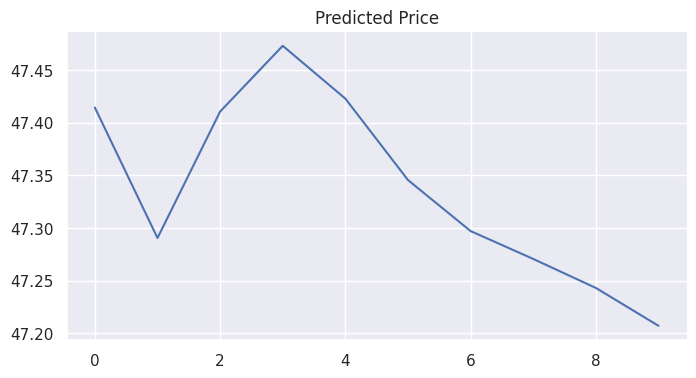

In [ ]:
from matplotlib import pyplot as plt
_df_20['Predicted Price'].plot(kind='line', figsize=(8, 4), title='Predicted Price')
plt.gca().spines[['top', 'right']].set_visible(False)

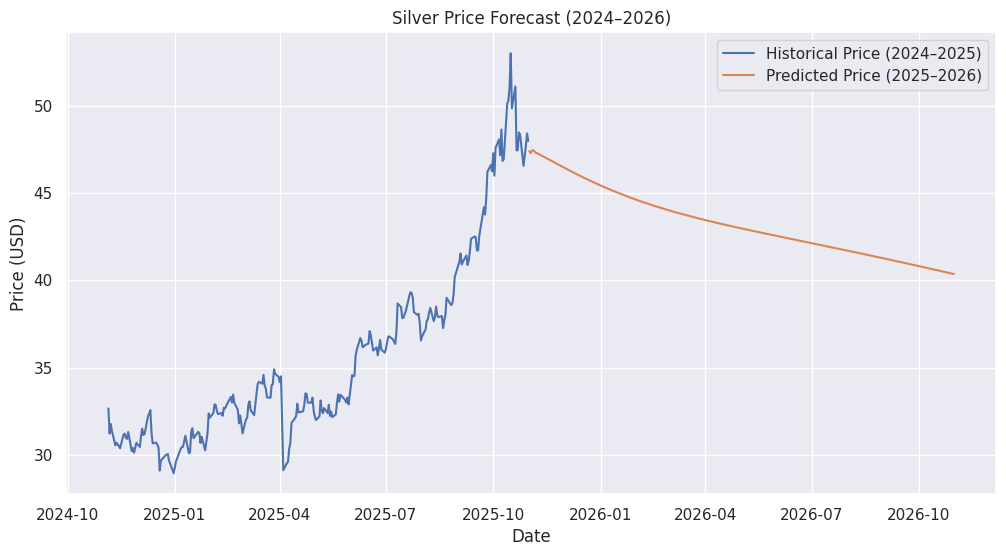

In [ ]:
# ---- Clean Visualization (2024–2026 only) ----

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Select only the last 250 days of actual historical prices (around 1 year)
recent_history = data.tail(250)

# Plot historical prices (2024–2025)
plt.plot(recent_history.index, recent_history['Close'], label="Historical Price (2024–2025)")

# Create future date index (start from last date + 1 day)
future_dates = pd.date_range(start=data.index[-1] + pd.Timedelta(days=1), periods=future_days)

# Plot predictions (2025–2026)
plt.plot(future_dates, predictions, label="Predicted Price (2025–2026)")

# Formatting
plt.title("Silver Price Forecast (2024–2026)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)

plt.show()
